# Linear regression on the energy efficiency dataset
In this notebook, I will perform linear regression on the energy efficiency dataset that can be fround [here](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). 

The features of the dataset are 

* X1 Relative Compactness
* X2 Surface Area
* X3 Wall Area
* X4 Roof Area
* X5 Overall Height
* X6 Orientation
* X7 Glazing Area
* X8 Glazing Area Distribution.

The labels are
* Y1 Heating Load
* Y2 Cooling Load.

There are 768 instances in the dataset. 

The structure of this notebook is as such:

1. Exploratory data analysis
2. Linear regression model - analytical solution
3. Linear regression - mini-batch stochastic gradient descent
4. Experiments

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from google.colab import drive 
drive.mount('/content/gdrive')
import warnings

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 1. Exploratory data analysis

In [ ]:
# create a dataframe for the dataset
ee_df = pd.read_excel('gdrive/My Drive/College/Classes/COMP551/ENB2012_data.xlsx')
#ee_df = ee_df.sample(frac = 1)  # shuffle the rows
ee_df.head()  # take a peek at the dataframe

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


We first look at the shape of the dataframe.

In [ ]:
ee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      768 non-null    float64
 1   X2      768 non-null    float64
 2   X3      768 non-null    float64
 3   X4      768 non-null    float64
 4   X5      768 non-null    float64
 5   X6      768 non-null    int64  
 6   X7      768 non-null    float64
 7   X8      768 non-null    int64  
 8   Y1      768 non-null    float64
 9   Y2      768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


It shows that all columns are complete. There are no missing data. The dataframe is clean and ready to be used.

For each feature, let's visualize the distribution.

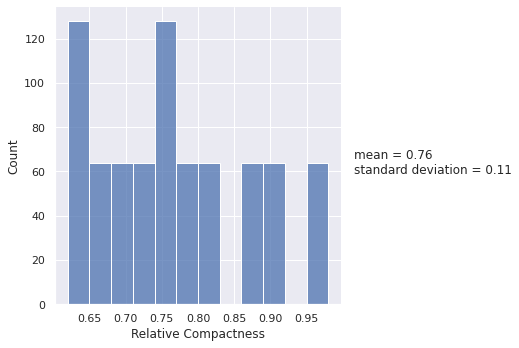

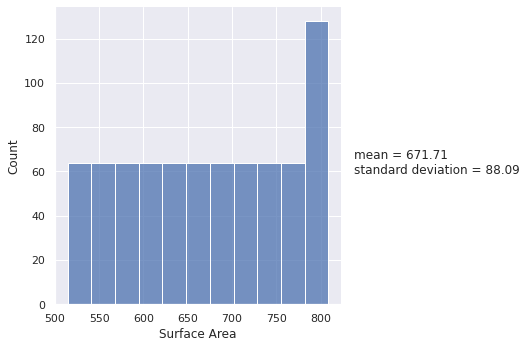

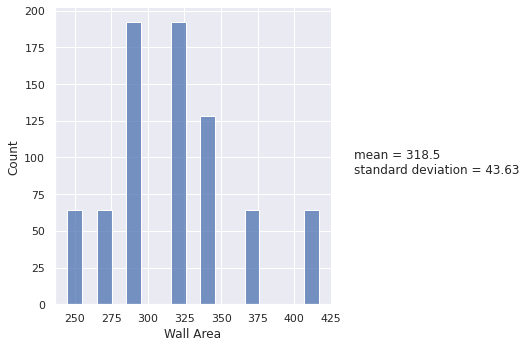

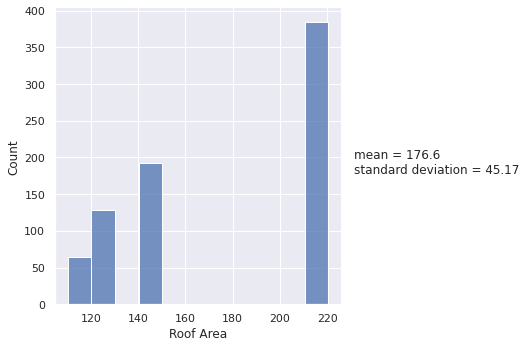

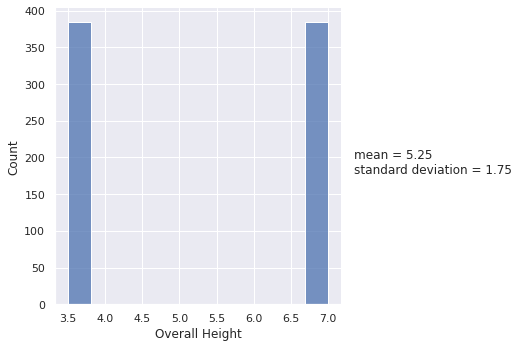

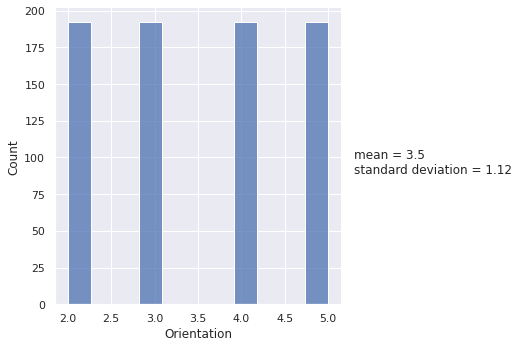

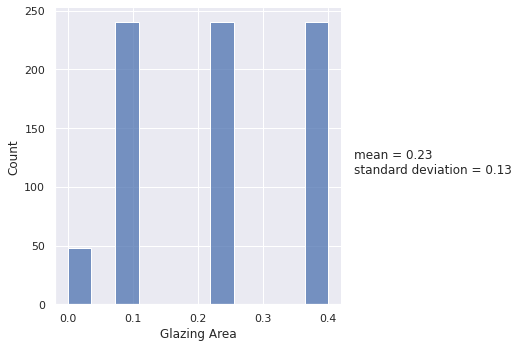

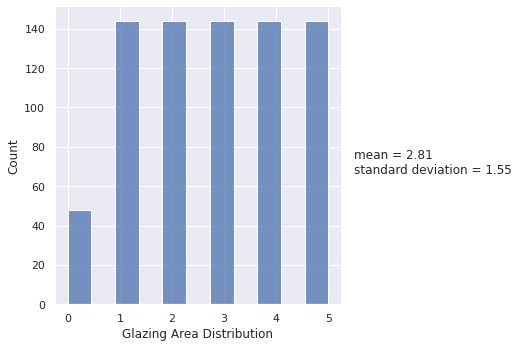

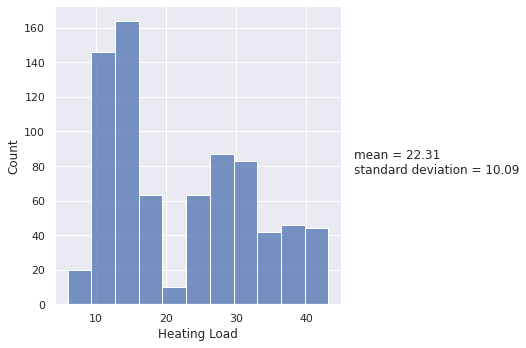

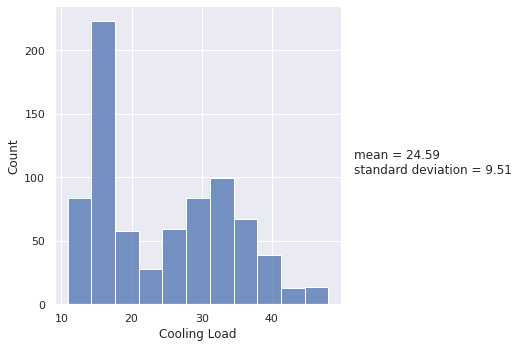

In [ ]:
sns.set(rc={'figure.figsize':(17,5)})
columns = list(ee_df)
columns_titles = ["Relative Compactness", "Surface Area", "Wall Area", \
                  "Roof Area", "Overall Height", "Orientation", "Glazing Area", \
                  "Glazing Area Distribution", "Heating Load", "Cooling Load"]
columns_mean = ee_df.mean()
columns_var = ee_df.var()
for i in range(len(columns)):
  sns.displot(data=ee_df, x=columns[i])
  plt.xlabel(columns_titles[i])
  plt.gcf().text(1, 0.5, f'mean = {round(columns_mean[i], 2)} \nstandard deviation = {round(math.sqrt(columns_var[i]), 2)}', fontsize=12)

# 2. Linear regression model - analytical solution
In this section, I will create a linear regression model.

In [ ]:
class LinearRegression:
    def __init__(self, add_bias=True): 
        self.add_bias = add_bias
        pass
    
    def fit(self, x, y, split=0.8):  # train on (split*100)% of the data
        train_size = math.trunc(len(x)*split)
        x_train, y_train = x.loc[:train_size], y.loc[:train_size]
        if x_train.ndim == 1:
            x_train = x_train[:, None]             # add a dimension for the features
        N = x_train.shape[0]                             # number of training instances
        if self.add_bias:
            x_train = np.column_stack([x_train,np.ones(N)])    # add bias by adding a constant feature of value 1
        #alternatively: self.w = np.linalg.inv(x.T @ x)@x.T@y
        self.w = np.linalg.lstsq(x_train, y_train)[0]    # return w

        # self.train_error = (np.linalg.lstsq(x_train, y_train)[1][0] / N)
        # I tried using the line of code above but it behaved weirdly. 
        # It works most of the time. But when split is of certain values (like 0.6),
        # it gives errors. So I think writing the code to calculate error myself is clearer.

        error = 0
        yh = x_train@self.w
        for i in range(len(yh)):
          error += (yh[i] - y_train[i]) ** 2
        error /= N
        self.train_error = error
        return self

    def test(self, x, y, split=0.8):  # test on ((1-split)*100)% of the data
        train_size = math.trunc(len(x)*split)
        x_test, y_test = x.loc[train_size:], y.loc[train_size:]
        if x_test.ndim == 1:
            x_test = x_test[:, None]                         # add a dimension for the features
        N = x_test.shape[0]                             # number of testing instances
        if self.add_bias:
            x_test = np.column_stack([x_test,np.ones(N)])
        yh = x_test@self.w                             # predict the y values
        error = 0
        for i in range(len(yh)):
          error += (yh[i] - y_test[train_size+i]) ** 2
        error /= N
        self.test_error = error
        return self
    
    def predict(self, x):
        N = x.shape[0] 
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w                             # predict the y values
        return yh

Now let's apply the linear regression model on the energy efficiency dataset. Let's first train the model with 80% of the datapoints and see how it performs on the test data.

In [ ]:
# Prepare the data
x = ee_df.iloc[:, :8]
y1 = ee_df['Y1']
y2 = ee_df['Y2']

model = LinearRegression()

In [ ]:
model.fit(x, y1)
model.test(x, y1)

<ipython-input-20-21ebf38f924a>:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.w = np.linalg.lstsq(x_train, y_train)[0]    # return w


In [ ]:
model.w

array([-6.37946910e+01, -3.23523859e+11,  3.23523859e+11,  6.47047717e+11,
        4.23761582e+00, -3.21496725e-02,  2.20742453e+01,  2.95048237e-01,
        8.01314755e+01])

In [ ]:
print('Model performance on Y1 (Heating Load):')
print(f'Training error: {model.train_error}')
print(f'Test error: {model.test_error}')

Model performance on Y1 (Heating Load):
Training error: 8.672051597377289
Test error: 9.631809792181432


In [ ]:
model.fit(x, y2)
model.test(x, y2)

<ipython-input-20-21ebf38f924a>:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.w = np.linalg.lstsq(x_train, y_train)[0]    # return w


In [ ]:
model.w

array([-6.92463510e+01, -2.07170441e+11,  2.07170441e+11,  4.14340883e+11,
        4.41484439e+00,  1.14921749e-01,  1.60956405e+01,  8.79856348e-02,
        9.19458010e+01])

In [ ]:
print('Model performance on Y2 (Cooling Load):')
print(f'Training error: {model.train_error}')
print(f'Test error: {model.test_error}')

Model performance on Y2 (Cooling Load):
Training error: 10.313623835177719
Test error: 10.244066988405786


Let's try the `predict()` function on Y2.

In [ ]:
predict_data = np.array([[0.98, 514.4, 294, 110.25, 7, 2, 0.1, 1]])
print(model.predict(predict_data), ', ', round(model.predict(predict_data)[0], 2))

[2.07170442e+10] ,  20717044161.28


This doesn't look right. Let's try to normalize the data first.

In [ ]:
ee_df_normalized = ee_df.copy()

for i in range(8):
  ee_df_normalized.iloc[:,i:i+1] = (ee_df_normalized.iloc[:,i:i+1] - ee_df_normalized.iloc[:,i:i+1].mean()) / \
  ee_df_normalized.iloc[:,i:i+1].std()

ee_df_normalized.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,2.040447,-1.784712,-0.561586,-1.469119,0.999349,-1.340767,-1.7593,-1.813393,15.55,21.33
1,2.040447,-1.784712,-0.561586,-1.469119,0.999349,-0.446922,-1.7593,-1.813393,15.55,21.33
2,2.040447,-1.784712,-0.561586,-1.469119,0.999349,0.446922,-1.7593,-1.813393,15.55,21.33
3,2.040447,-1.784712,-0.561586,-1.469119,0.999349,1.340767,-1.7593,-1.813393,15.55,21.33
4,1.284142,-1.228438,0.000000,-1.197897,0.999349,-1.340767,-1.7593,-1.813393,20.84,28.28


Then let's test the model again.

In [ ]:
warnings.filterwarnings('ignore')

x = ee_df_normalized.iloc[:, :8]
y1 = ee_df_normalized['Y1']
y2 = ee_df_normalized['Y2']

model = LinearRegression()
model.fit(x, y1)
model.test(x, y1)
print('Model performance on Y1 (Heating Load):')
print(f'Training error: {model.train_error}')
print(f'Test error: {model.test_error}')
print(f'Weights: {model.w}')
model.fit(x, y2)
model.test(x, y2)
print()
print('Model performance on Y2 (Cooling Load):')
print(f'Training error: {model.train_error}')
print(f'Test error: {model.test_error}')
print(f'Weights: {model.w}')

warnings.filterwarnings('default')

Model performance on Y1 (Heating Load):
Training error: 9.280695233210652
Test error: 12.419995533183627
Weights: [-4.54642156e+00  7.80563091e+14 -3.86590109e+14 -8.00463803e+14
  8.15625000e+00  2.41088867e-01  3.45605469e+00  1.65039062e-01
  2.32568359e+01]

Model performance on Y2 (Cooling Load):
Training error: 10.415574988692713
Test error: 10.336605027426666
Weights: [-5.78240493e+00  5.45370294e+14 -2.70105984e+14 -5.59274689e+14
  8.12500000e+00  2.46826172e-01  2.17187500e+00  3.24707031e-02
  2.52138672e+01]


Let's try the `predict()` function.

In [ ]:
def input_normalizer(df, input_np_array):
  columns_mean = df.mean()
  columns_std = df.std()

  input_list = input_np_array.tolist()
  output_list = []

  for i in range(len(input_list)):
    output_sublist = []
    for j in range(len(input_list[0])):
      normalized_datum = (input_list[i][j] - columns_mean[j]) / columns_std[j]
      output_sublist.append(normalized_datum)
    output_list.append(output_sublist)
  
  return np.array(output_list)

In [ ]:
predict_data = np.array([[0.98, 514.4, 294, 110.25, 7, 2, 0.1, 1]])
normalized_predict_data = input_normalizer(ee_df, predict_data)
print(model.predict(normalized_predict_data), ', ', round(model.predict(normalized_predict_data)[0], 2))

[-6.19133092e+11] ,  -619133092416.1


# 3. Linear regression - mini-batch stochastic gradient descent

In this section, instead of analytically calculating the weights of the features, I will use mini-batch stochastic gradient descent to calculate the weights.

In [ ]:
class LinearRegressionMBSGD:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass

    def MBSGD(self, x, y, batch_size, learning_rate, lr_scheduling, max_iters, eps):
        N, D = x.shape
        w = np.zeros(D)  # initialize weights to zeros
        g = np.inf  # initialize gradient to infinity

        def gradient(x_batch, y_batch, w):
            N, D = x_batch.shape
            yh = np.dot(x_batch, w)
            grad = np.dot(x_batch.T, yh - y_batch) / N
            return grad

        num_of_batches = math.trunc(N / batch_size)

        t = 1
        batch_index = 0
        alpha = learning_rate

        while np.linalg.norm(g) > eps and t < max_iters:
            x_mini_batch = x[batch_index * batch_size:batch_index * batch_size + batch_size, :]
            y_mini_batch = y[batch_index * batch_size:batch_index * batch_size + batch_size]
            g = gradient(x_mini_batch, y_mini_batch, w)
            #alpha = t ** (-0.51)
            w = w - alpha * g
            batch_index = (batch_index + 1) % num_of_batches
            t += 1
        self.iterations = t
        return w

    def fit(self, x, y, split=0.8, batch_size=32, learning_rate=0.01, lr_scheduling=False, max_iters=10000,
            eps=1e-2):  # train on (split*100)% of the data
        train_size = math.trunc(len(x) * split)
        x_train, y_train = x.loc[:train_size], y.loc[:train_size].to_numpy()
        if x_train.ndim == 1:
            x_train = x_train[:, None]  # add a dimension for the features
        N = x_train.shape[0]  # number of training instances
        if self.add_bias:
            x_train = np.column_stack([x_train, np.ones(N)])  # add bias by adding a constant feature of value 1

        self.w = self.MBSGD(x_train, y_train, batch_size, learning_rate, lr_scheduling, max_iters, eps)

        error = 0
        yh = x_train @ self.w
        for i in range(len(yh)):
            error += (yh[i] - y_train[i]) ** 2
        error /= N
        self.train_error = error
        return self

    def test(self, x, y, split=0.8):  # test on ((1-split)*100)% of the data
        train_size = math.trunc(len(x) * split)
        x_test, y_test = x.loc[train_size:], y.loc[train_size:]
        if x_test.ndim == 1:
            x_test = x_test[:, None]  # add a dimension for the features
        N = x_test.shape[0]  # number of testing instances
        if self.add_bias:
            x_test = np.column_stack([x_test, np.ones(N)])
        yh = x_test @ self.w  # predict the y values
        error = 0
        for i in range(len(yh)):
            error += (yh[i] - y_test[train_size + i]) ** 2
        error /= N
        self.test_error = error
        return self

    def predict(self, x):
        N = len(x)
        if self.add_bias:
            x = np.column_stack([x, np.ones(N)])
        yh = x @ self.w  # predict the y values
        return yh

Now let's train the model. The code is going to take some time to run. I have tried larger learning rates, which resulted in divergence. The reason, I suppose, is that in the mini-batch stochastic gradient descent model built above, no learning rate scheduling or momentum were used. Therefore, the gradient descent osciilates a lot with larger learning rates. Using a learning rate of 0.000001 means that the weights converge slowly. To compensate this, I set the max iterations allowed at 1000000.

In [ ]:
x = ee_df.iloc[:, :8]
y1 = ee_df['Y1']
y2 = ee_df['Y2']

model = LinearRegressionMBSGD()

In [ ]:
model.fit(x, y1, learning_rate=0.000001, max_iters=1000000)
model.test(x, y1)

Let's look at the weights returned by the training model.

In [ ]:
model.w

array([ 0.20228709, -0.01342961,  0.07560079, -0.0445152 ,  2.38315181,
        0.20121224,  0.27080593,  0.62132318,  0.14253253])

In [ ]:
print('Model performance on Y1 (Heating Load):')
print(f'Training error: {model.train_error}')
print(f'Test error: {model.test_error}')

Model performance on Y1 (Heating Load):
Training error: 18.727550781791468
Test error: 14.042614102518971


Now, I will try the model on Y2. For Y2, let's experiment with max_iters=1000000 and max_iters=1000000.

In [ ]:
model.fit(x, y2, learning_rate=0.000001, max_iters=1000000) 
model.test(x, y2)

In [ ]:
model.w

array([ 0.23728358, -0.00872709,  0.06285574, -0.03579141,  2.67907685,
        0.34312205,  0.22444494,  0.47342797,  0.16557567])

In [ ]:
print('Model performance on Y2 (Cooling Load):')
print(f'Training error: {model.train_error}')
print(f'Test error: {model.test_error}')
print(f'Iterations used: {model.iterations}')

Model performance on Y2 (Cooling Load):
Training error: 17.252610580042624
Test error: 13.5203201714334
Iterations used: 1000000


Try out prediction:

In [ ]:
predict_data = np.array([[0.98, 514.4, 294, 110.25, 7, 2, 0.1, 1]])
print(model.predict(predict_data), ', ', round(model.predict(predict_data)[0], 2))

[30.37813504] ,  30.38


In [ ]:
model.fit(x, y2, learning_rate=0.000001, max_iters=10000000)
model.test(x, y2)

In [ ]:
model.w

array([-0.31498133, -0.00643639,  0.04481275, -0.02562457,  3.40410177,
        0.0224597 ,  1.6015134 ,  0.27457939, -0.09199129])

In [ ]:
print('Model performance on Y2 (Cooling Load):')
print(f'Training error: {model.train_error}')
print(f'Test error: {model.test_error}')
print(f'Iterations used: {model.iterations}')

Model performance on Y2 (Cooling Load):
Training error: 14.912754192921385
Test error: 13.962695630213544
Iterations used: 10000000


Setting max_iters at 10000000 did not improve the model that much. But it took 10 times longer to run.

As in section 3, let's try normalizing the inputs.

In [ ]:
warnings.filterwarnings('ignore')

x = ee_df_normalized.iloc[:, :8]
y1 = ee_df_normalized['Y1']
y2 = ee_df_normalized['Y2']

model = LinearRegressionMBSGD()
model.fit(x, y1, learning_rate=0.000001, max_iters=1000000)
model.test(x, y1)
print('Model performance on Y1 (Heating Load), learning rate=0.000001, max_iters=1000000, data normalized:')
print(f'Training error: {model.train_error}')
print(f'Test error: {model.test_error}')
print(f'Weights: {model.w}')
print(f'Iterations used: {model.iterations}')
print()
model.fit(x, y1, learning_rate=0.01, max_iters=1000000)
model.test(x, y1)
print('Model performance on Y1 (Heating Load), learning rate=0.01, max_iters=1000000, data normalized:')
print(f'Training error: {model.train_error}')
print(f'Test error: {model.test_error}')
print(f'Weights: {model.w}')
print(f'Iterations used: {model.iterations}')


warnings.filterwarnings('default')

Model performance on Y1 (Heating Load), learning rate=0.000001, max_iters=1000000, data normalized:
Training error: 88.49204000524695
Test error: 211.27040133243779
Weights: [ 1.17015966 -1.47558469  2.34202595 -2.5699988   2.96521925 -0.02077383
 -1.2478057  -0.98204232 13.32427973]
Iterations used: 1000000

Model performance on Y1 (Heating Load), learning rate=0.01, max_iters=1000000, data normalized:
Training error: 8.668263600066194
Test error: 9.72844380257559
Weights: [-6.87497848 -3.59509268  0.65134401 -3.82028493  7.3765924  -0.03251876
  2.98950792  0.44375543 22.63902638]
Iterations used: 1000000


Using normalized data, the model can learn faster given the same `max_iters`. The errors are also smaller.

# 4. Experiments

In this section, I will experiment using different parameters in the model and compare the performance.

## Task 1: Performance of the linear regression model using analytical solution 

Here, I will report the performance of the linear regression model using a 80/20 train/test split. I will report the weight of each feature and its effect on the output.



In [ ]:
x = ee_df.iloc[:, :8]
y1 = ee_df['Y1']
y2 = ee_df['Y2']

model = LinearRegression()

model.fit(x, y1)
model.test(x, y1)

<ipython-input-20-21ebf38f924a>:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.w = np.linalg.lstsq(x_train, y_train)[0]    # return w


In [ ]:
print('Model performance on Y1 (Heating Load):')
print(f'Training error: {model.train_error}')
print(f'Test error: {model.test_error}')

Model performance on Y1 (Heating Load):
Training error: 8.672051597377289
Test error: 9.631809792181432


The model's performances on training and test datasets are similar, giving mean squared errors of 8.67 and 9.63 respectively.

In [ ]:
print("Model weights for Y1")
for i in range(8):
  print(f'X{i+1} weight: {model.w[i]}')

print(f'Bias weight: {model.w[8]}')

Model weights for Y1
X1 weight: -63.7946909891699
X2 weight: -323523858714.04175
X3 weight: 323523858714.0173
X4 weight: 647047717427.9193
X5 weight: 4.2376158237457275
X6 weight: -0.032149672508239746
X7 weight: 22.07424532622099
X8 weight: 0.29504823684692383
Bias weight: 80.13147553801537


For Y1(Heating Load), X1, X2, and X6 have negative impacts on the output. whereas X3, X4, X5, X7, and X8 have positive impacts on the output. X2, X3, and X4 have especially large influence over the output.

## Task 2: Train/test split ratio

In this section I will change the train/test ratio and see how it affects the performance.

<ipython-input-20-21ebf38f924a>:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.w = np.linalg.lstsq(x_train, y_train)[0]    # return w


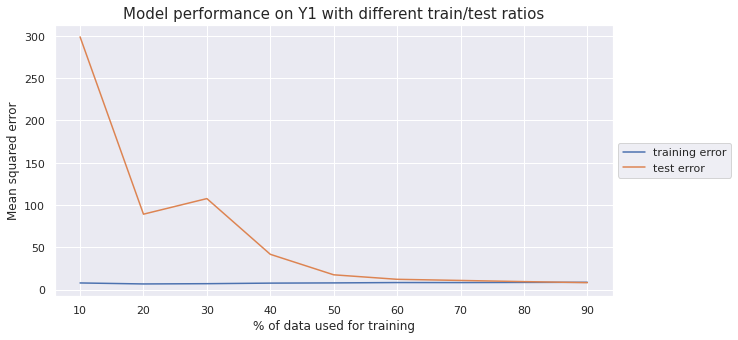

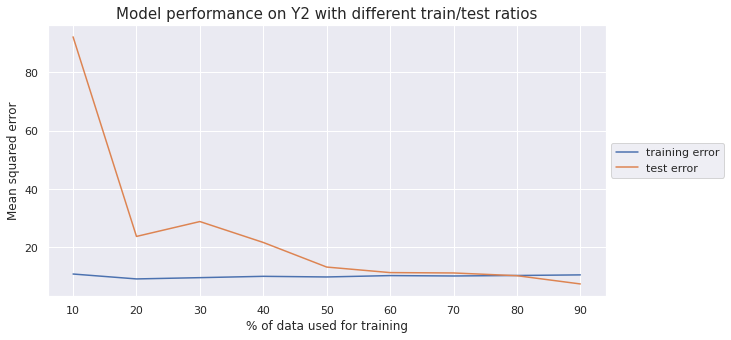

In [ ]:
x = ee_df.iloc[:, :8]
y1 = ee_df['Y1']
y2 = ee_df['Y2']

model = LinearRegression()

sns.set(rc={'figure.figsize':(10,5)})

# for Y1
Y1_ratios = []
Y1_train_errors = []
Y1_test_errors = []

for i in range(1, 10):
  model.fit(x, y1, split=i/10)
  model.test(x, y1, split=i/10)
  Y1_ratios.append(i*10)
  Y1_train_errors.append(model.train_error)
  Y1_test_errors.append(model.test_error)

plt.plot(Y1_ratios, Y1_train_errors, label = "training error")
plt.plot(Y1_ratios, Y1_test_errors, label = "test error")

plt.title("Model performance on Y1 with different train/test ratios", size=15)
plt.xlabel("% of data used for training")
plt.ylabel("Mean squared error")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# for Y2
Y2_ratios = []
Y2_train_errors = []
Y2_test_errors = []

for i in range(1, 10):
  model.fit(x, y2, split=i/10)
  model.test(x, y2, split=i/10)
  Y2_ratios.append(i*10)
  Y2_train_errors.append(model.train_error)
  Y2_test_errors.append(model.test_error)

plt.plot(Y2_ratios, Y2_train_errors, label = "training error")
plt.plot(Y2_ratios, Y2_test_errors, label = "test error")

plt.title("Model performance on Y2 with different train/test ratios", size=15)
plt.xlabel("% of data used for training")
plt.ylabel("Mean squared error")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

We can see that the training errors are consistently low, but test errors are lower with higher percentages of data used for training.

## Task 3: Different batch sizes in mini-batch stochastic gradient descent

To carry out this task, I will use the normalized model since it is more accurate. The effect of batch size can then be emphasized. The learning is set at 0.01 and the train/test split is set at 80/20. max_iters is set at 1000000.

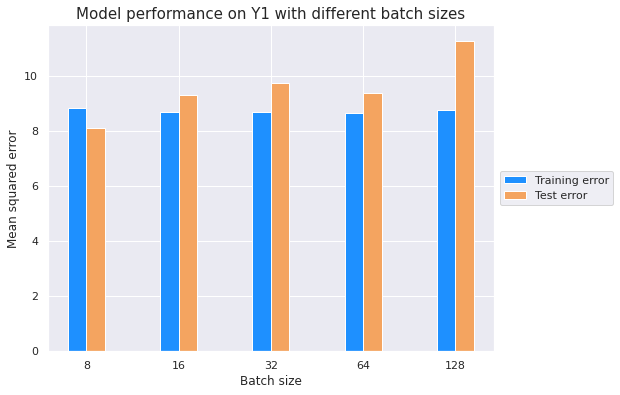

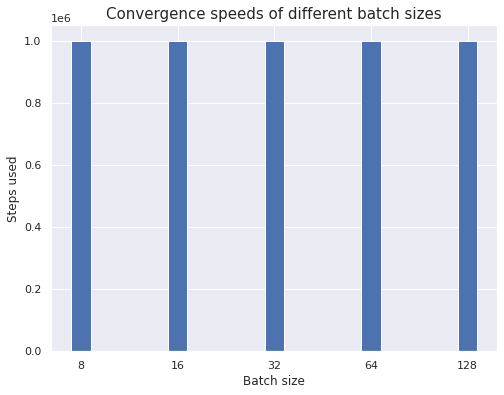

In [ ]:
x = ee_df_normalized.iloc[:, :8]
y1 = ee_df_normalized['Y1']
y2 = ee_df_normalized['Y2']

model = LinearRegressionMBSGD()
batch_sizes = ["8", "16", "32", "64", "128"]
Y1_train_errors = []
Y1_test_errors = []
speed = []

for bs in batch_sizes:
  model.fit(x, y1, batch_size=int(bs), learning_rate=0.01, max_iters=1000000)
  model.test(x, y1)
  Y1_train_errors.append(model.train_error)
  Y1_test_errors.append(model.test_error)
  speed.append(model.iterations)


sns.set(rc={'figure.figsize':(8,6)})
N = 5
ind = np.arange(N) 
width = 0.2

bar1 = plt.bar(ind+(0.5*width), Y1_train_errors, width, color = 'dodgerblue')
bar2 = plt.bar(ind+(1.5*width), Y1_test_errors, width, color='sandybrown')

plt.xlabel("Batch size")
plt.ylabel('Mean squared error')
plt.title("Model performance on Y1 with different batch sizes", size=15)
plt.xticks(ind+width, batch_sizes)
plt.legend((bar1, bar2), ('Training error', 'Test error'), loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

sns.set(rc={'figure.figsize':(8,6)})

bar = plt.bar(ind, speed, width)
plt.xlabel("Batch size")
plt.ylabel('Steps used')
plt.xticks(ind, batch_sizes)
plt.title("Convergence speeds of different batch sizes", size=15)
plt.show()

All batch sizes used up the maximum iterations allowed. 

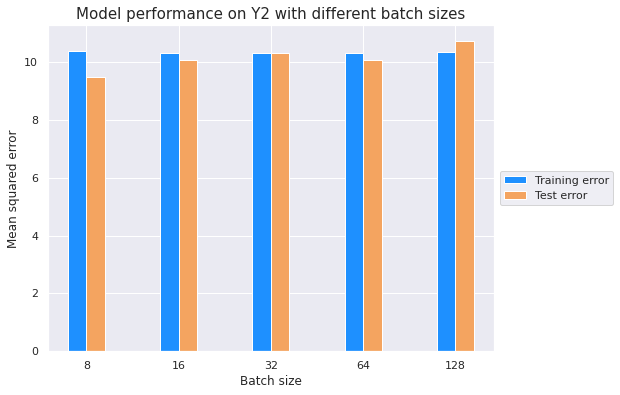

In [ ]:
Y2_train_errors = []
Y2_test_errors = []

for bs in batch_sizes:
  model.fit(x, y2, batch_size=int(bs), learning_rate=0.01, max_iters=1000000)
  model.test(x, y2)
  Y2_train_errors.append(model.train_error)
  Y2_test_errors.append(model.test_error)
  speed.append(model.iterations)


sns.set(rc={'figure.figsize':(8,6)})
N = 5
ind = np.arange(N) 
width = 0.2

bar1 = plt.bar(ind+(0.5*width), Y2_train_errors, width, color = 'dodgerblue')
bar2 = plt.bar(ind+(1.5*width), Y2_test_errors, width, color='sandybrown')

plt.xlabel("Batch size")
plt.ylabel('Mean squared error')
plt.title("Model performance on Y2 with different batch sizes", size=15)
plt.xticks(ind+width, batch_sizes)
plt.legend((bar1, bar2), ('Training error', 'Test error'), loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

For both Y1 and Y2, training errors are relatively consistent, but smaller batch sizes generally give better test erros, with the exception being batch size 64. Among all batch sizes tried, batch size 8 works the best.

## Task 4: Different learning rates in mini-batch stochastic gradient descent

Same as above, I will use the normalized model and a train/test split of 80/20. Batch size is set at 16. max_iters is 1000000.


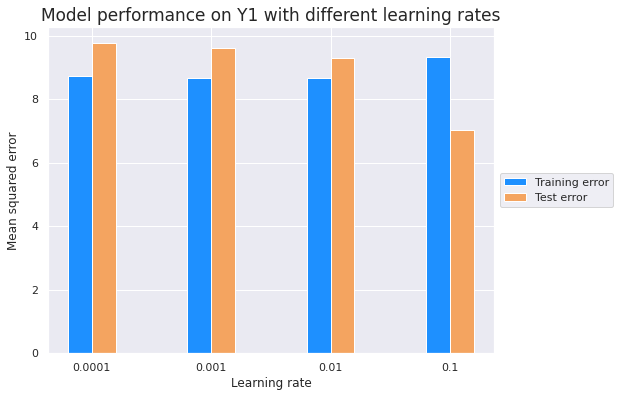

In [ ]:
x = ee_df_normalized.iloc[:, :8]
y1 = ee_df_normalized['Y1']
y2 = ee_df_normalized['Y2']

model = LinearRegressionMBSGD()
learning_rates = ["0.0001", "0.001", "0.01", "0.1"]
Y1_train_errors = []
Y1_test_errors = []

for lr in learning_rates:
  model.fit(x, y1, batch_size=16, learning_rate=float(lr), max_iters=1000000)
  model.test(x, y1)
  Y1_train_errors.append(model.train_error)
  Y1_test_errors.append(model.test_error)
  speed.append(model.iterations)


sns.set(rc={'figure.figsize':(8,6)})
N = 4
ind = np.arange(N) 
width = 0.2

bar1 = plt.bar(ind+(0.5*width), Y1_train_errors, width, color = 'dodgerblue')
bar2 = plt.bar(ind+(1.5*width), Y1_test_errors, width, color='sandybrown')

plt.xlabel("Learning rate")
plt.ylabel('Mean squared error')
plt.title("Model performance on Y1 with different learning rates", size=17)
plt.xticks(ind+width, learning_rates)
plt.legend((bar1, bar2), ('Training error', 'Test error'), loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Training errors are relatively consistent with learning rates 0.0001, 0.001, and 0.01; however, it increases with a learning rate of 0.1. Meanwhile test erros decreases as the learning rate increases.

## Task 5: Comparing analytical solution and mini-batch stochastic gradient descent solution

Below I will compare the performance of linear regression models using analytical solution and mini-batch stochastic gradient descent respectively. Both use normalized data.

For mini-batch stochastic gradient descent, the parameters are as such:
* learning rate: 0.01
* batch size: 8
* maximum iterations allowed: 1000000
* train/test split: 80/20.

For the analytical solution, train/test ratio is also 80/20.

<ipython-input-20-21ebf38f924a>:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.w = np.linalg.lstsq(x_train, y_train)[0]    # return w


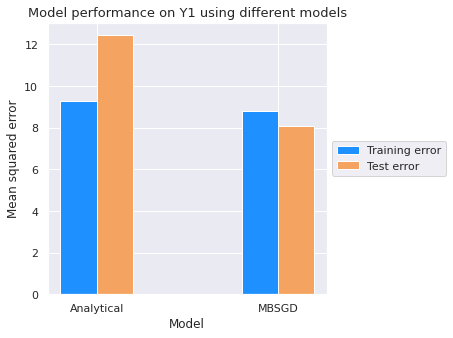

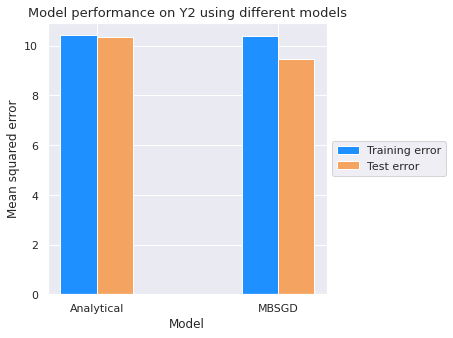

In [ ]:
x = ee_df_normalized.iloc[:, :8]
y1 = ee_df_normalized['Y1']
y2 = ee_df_normalized['Y2']

solutions = ['Analytical', 'MBSGD']
Y1_train_errors = []
Y1_test_errors = []
Y2_train_errors = []
Y2_test_errors = []

# Analytical solution on Y1
model = LinearRegression()
model.fit(x, y1)
model.test(x, y1)
Y1_train_errors.append(model.train_error)
Y1_test_errors.append(model.test_error)

# Analytical solution on Y2
model.fit(x, y2)
model.test(x, y2)
Y2_train_errors.append(model.train_error)
Y2_test_errors.append(model.test_error)

model = LinearRegressionMBSGD()

# MBSGD solution on Y1
model.fit(x, y1, batch_size=8, learning_rate=0.01, max_iters=1000000)
model.test(x, y1)
Y1_train_errors.append(model.train_error)
Y1_test_errors.append(model.test_error)

# MBSGD solution on Y2
model.fit(x, y2, batch_size=8, learning_rate=0.01, max_iters=1000000)
model.test(x, y2)
Y2_train_errors.append(model.train_error)
Y2_test_errors.append(model.test_error)

# plot
sns.set(rc={'figure.figsize':(5,5)})
N = 2
ind = np.arange(N) 
width = 0.2

bar1 = plt.bar(ind+(0.5*width), Y1_train_errors, width, color = 'dodgerblue')
bar2 = plt.bar(ind+(1.5*width), Y1_test_errors, width, color='sandybrown')

plt.xlabel("Model")
plt.ylabel('Mean squared error')
plt.title("Model performance on Y1 using different models", size=13)
plt.xticks(ind+width, solutions)
plt.legend((bar1, bar2), ('Training error', 'Test error'), loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


bar1 = plt.bar(ind+(0.5*width), Y2_train_errors, width, color = 'dodgerblue')
bar2 = plt.bar(ind+(1.5*width), Y2_test_errors, width, color='sandybrown')

plt.xlabel("Model")
plt.ylabel('Mean squared error')
plt.title("Model performance on Y2 using different models", size=13)
plt.xticks(ind+width, solutions)
plt.legend((bar1, bar2), ('Training error', 'Test error'), loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The model using mini-batch stochastic gradient descent performs better. For Y1 especially, the analytical solution overfit.

## Task 6: Mini-batch stochastic gradient descent with ADAM

In this task, I will apply Adaptive Moment Estimation (ADAM) on the mini-batch stochastic gradient dscent. The hyperparameters are as such:

* learning rate: 0.1
* batch size: 16
* beta 1: 0.9
* beta 2: 0.999
* noise: 1e-8
* train/test ratio: 80/20
* maximum iterations allowed: 1000000

In [ ]:
class LinearRegressionMBSGD_ADAM:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass

    def MBSGD(self, x, y, beta1, beta2, batch_size, learning_rate, max_iters, eps, noise):
        N, D = x.shape
        w = np.zeros(D)  # initialize weights to zeros
        g = np.inf  # initialize gradient to infinity
        m  = 0
        v = 0
        t = 0
        alpha = learning_rate

        def gradient(x_batch, y_batch, w):
            N, D = x_batch.shape
            yh = np.dot(x_batch, w)
            grad = np.dot(x_batch.T, yh - y_batch) / N
            return grad

        num_of_batches = math.trunc(N / batch_size)
        batch_index = 0
        
        while np.linalg.norm(g) > eps and t < max_iters:
            t += 1
            x_mini_batch = x[batch_index * batch_size:batch_index * batch_size + batch_size, :]
            y_mini_batch = y[batch_index * batch_size:batch_index * batch_size + batch_size]
            g = gradient(x_mini_batch, y_mini_batch, w)
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * (g ** 2)
            m_hat = m / (1 - beta1 ** t)
            v_hat = v / (1 - beta2 ** t)
            w = w - alpha * m_hat / (np.square(v_hat) + noise)
            batch_index = (batch_index + 1) % num_of_batches

        self.iterations = t
        return w

    def fit(self, x, y, beta1=0.9, beta2=0.999, split=0.8, batch_size=16, \
            learning_rate=0.1, max_iters=1000000, eps=1e-2, noise=1e-8):
        train_size = math.trunc(len(x) * split)
        x_train, y_train = x.loc[:train_size], y.loc[:train_size].to_numpy()
        if x_train.ndim == 1:
            x_train = x_train[:, None]  # add a dimension for the features
        N = x_train.shape[0]  # number of training instances
        if self.add_bias:
            x_train = np.column_stack([x_train, np.ones(N)])  # add bias by adding a constant feature of value 1

        self.w = self.MBSGD(x_train, y_train, beta1, beta2, batch_size, learning_rate, max_iters, eps, noise)

        error = 0
        yh = x_train @ self.w
        for i in range(len(yh)):
            error += (yh[i] - y_train[i]) ** 2
        error /= N
        self.train_error = error
        return self

    def test(self, x, y, split=0.8): 
        train_size = math.trunc(len(x) * split)
        x_test, y_test = x.loc[train_size:], y.loc[train_size:]
        if x_test.ndim == 1:
            x_test = x_test[:, None]  # add a dimension for the features
        N = x_test.shape[0]  # number of testing instances
        if self.add_bias:
            x_test = np.column_stack([x_test, np.ones(N)])
        yh = x_test @ self.w  # predict the y values
        error = 0
        for i in range(len(yh)):
            error += (yh[i] - y_test[train_size + i]) ** 2
        error /= N
        self.test_error = error
        return self

    def predict(self, x):
        N = len(x)
        if self.add_bias:
            x = np.column_stack([x, np.ones(N)])
        yh = x @ self.w  # predict the y values
        return yh

Let's apply the model on Y1 on both un-normalized data and normalized data.

In [ ]:
# not normalized

x = ee_df.iloc[:, :8]
y1 = ee_df['Y1']

model = LinearRegressionMBSGD_ADAM()
model.fit(x, y1)
model.test(x, y1)

In [ ]:
model.w

array([ 1.65238823e+01, -5.53316931e-07,  1.98369237e-05, -1.27011957e-03,
        2.97911264e+00, -1.63480649e-02,  2.36212071e+01,  2.54425311e-01,
       -1.14280261e+01])

In [ ]:
print('Model performance on Y1 (Heating Load):')
print(f'Training error: {model.train_error}')
print(f'Test error: {model.test_error}')
print(f'Iterations used: {model.iterations}')

Model performance on Y1 (Heating Load):
Training error: 23.54902552445526
Test error: 27.413207812528295
Iterations used: 1000000


In [ ]:
predict_data = np.array([[0.98, 514.4, 294, 110.25, 7, 2, 0.1, 1]])
print(model.predict(predict_data), ', ', round(model.predict(predict_data)[0], 2))

[28.06853362] ,  28.07


The model gives larger. Let's try the model on normalized data.

In [ ]:
# normalized
x = ee_df_normalized.iloc[:, :8]
y1 = ee_df_normalized['Y1']

model = LinearRegressionMBSGD_ADAM()
model.fit(x, y1)
model.test(x, y1)

In [ ]:
model.w

array([-6.89537057, -6.65460736,  2.14134808, -0.69530026,  7.3525638 ,
       -0.14950265,  2.98571959,  0.45007596, 22.6400372 ])

In [ ]:
print('Model performance on Y1 (Heating Load):')
print(f'Training error: {model.train_error}')
print(f'Test error: {model.test_error}')
print(f'Iterations used: {model.iterations}')

Model performance on Y1 (Heating Load):
Training error: 8.690497186443803
Test error: 9.832385192675924
Iterations used: 1000000


In [ ]:
predict_data = np.array([[0.98, 514.4, 294, 110.25, 7, 2, 0.1, 1]])
normalized_predict_data = input_normalizer(ee_df, predict_data)
print(model.predict(normalized_predict_data), ', ', round(model.predict(normalized_predict_data)[0], 2))

[24.28409722] ,  24.28


Let's try the model with different batch sizes and learning rates.

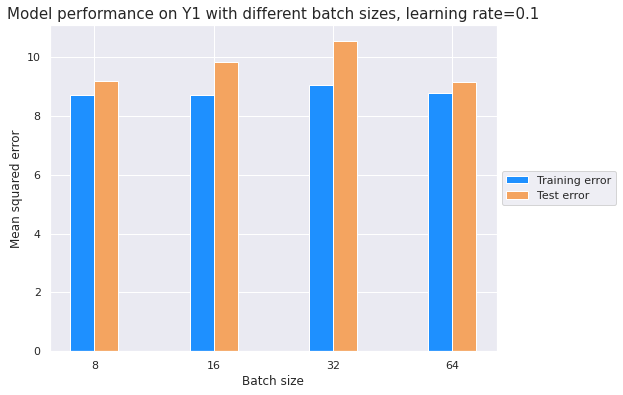

In [ ]:
x = ee_df_normalized.iloc[:, :8]
y1 = ee_df_normalized['Y1']

model = LinearRegressionMBSGD_ADAM()
batch_sizes = ["8", "16", "32", "64"]
Y1_train_errors = []
Y1_test_errors = []

for bs in batch_sizes:
  model.fit(x, y1, batch_size=int(bs), learning_rate=0.1, max_iters=1000000)
  model.test(x, y1)
  Y1_train_errors.append(model.train_error)
  Y1_test_errors.append(model.test_error)


sns.set(rc={'figure.figsize':(8,6)})
N = 4
ind = np.arange(N) 
width = 0.2

bar1 = plt.bar(ind+(0.5*width), Y1_train_errors, width, color = 'dodgerblue')
bar2 = plt.bar(ind+(1.5*width), Y1_test_errors, width, color='sandybrown')

plt.xlabel("Batch size")
plt.ylabel('Mean squared error')
plt.title("Model performance on Y1 with different batch sizes, learning rate=0.1", size=15)
plt.xticks(ind+width, batch_sizes)
plt.legend((bar1, bar2), ('Training error', 'Test error'), loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Batch sizes 8 and 64 perform better.

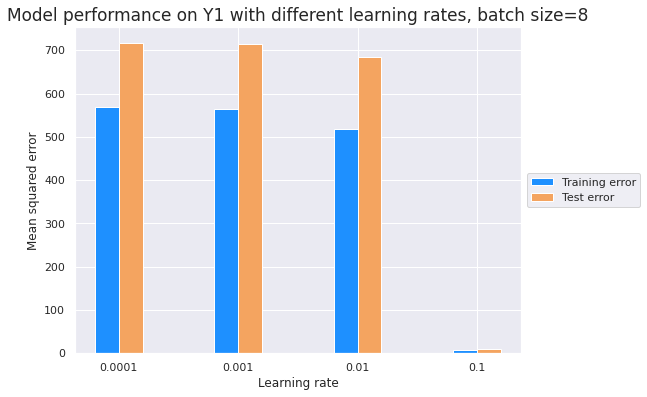

In [ ]:
model = LinearRegressionMBSGD_ADAM()
learning_rates = ["0.0001", "0.001", "0.01", "0.1"]
Y1_train_errors = []
Y1_test_errors = []

for lr in learning_rates:
  model.fit(x, y1, batch_size=8, learning_rate=float(lr), max_iters=1000000)
  model.test(x, y1)
  Y1_train_errors.append(model.train_error)
  Y1_test_errors.append(model.test_error)
  speed.append(model.iterations)


sns.set(rc={'figure.figsize':(8,6)})
N = 4
ind = np.arange(N) 
width = 0.2

bar1 = plt.bar(ind+(0.5*width), Y1_train_errors, width, color = 'dodgerblue')
bar2 = plt.bar(ind+(1.5*width), Y1_test_errors, width, color='sandybrown')

plt.xlabel("Learning rate")
plt.ylabel('Mean squared error')
plt.title("Model performance on Y1 with different learning rates, batch size=8", size=17)
plt.xticks(ind+width, learning_rates)
plt.legend((bar1, bar2), ('Training error', 'Test error'), loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Learning rate of 0.1 gives significantly smaller error. This is due to the faster learning of the ADAM algorithm.

Let's compare it with the other two models. Batch size is 8 for both MBSGD and ADAM.

<ipython-input-20-21ebf38f924a>:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.w = np.linalg.lstsq(x_train, y_train)[0]    # return w


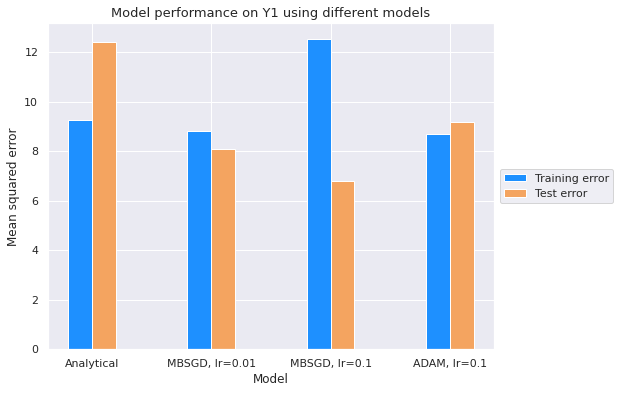

In [ ]:
x = ee_df_normalized.iloc[:, :8]
y1 = ee_df_normalized['Y1']

solutions = ['Analytical', 'MBSGD, lr=0.01', 'MBSGD, lr=0.1', 'ADAM, lr=0.1']
Y1_train_errors = []
Y1_test_errors = []

# Analytical solution on Y1
model = LinearRegression()
model.fit(x, y1)
model.test(x, y1)
Y1_train_errors.append(model.train_error)
Y1_test_errors.append(model.test_error)

# MBSGD solution on Y1
model = LinearRegressionMBSGD()
model.fit(x, y1, batch_size=8, learning_rate=0.01, max_iters=1000000)
model.test(x, y1)
Y1_train_errors.append(model.train_error)
Y1_test_errors.append(model.test_error)

model = LinearRegressionMBSGD()
model.fit(x, y1, batch_size=8, learning_rate=0.1, max_iters=1000000)
model.test(x, y1)
Y1_train_errors.append(model.train_error)
Y1_test_errors.append(model.test_error)

# MBSGD-ADAM solution on Y1
model = LinearRegressionMBSGD_ADAM()
model.fit(x, y1, batch_size=8, learning_rate=0.1, max_iters=1000000)
model.test(x, y1)
Y1_train_errors.append(model.train_error)
Y1_test_errors.append(model.test_error)


# plot
sns.set(rc={'figure.figsize':(8,6)})
N = 4
ind = np.arange(N) 
width = 0.2

bar1 = plt.bar(ind+(0.5*width), Y1_train_errors, width, color = 'dodgerblue')
bar2 = plt.bar(ind+(1.5*width), Y1_test_errors, width, color='sandybrown')

plt.xlabel("Model")
plt.ylabel('Mean squared error')
plt.title("Model performance on Y1 using different models", size=13)
plt.xticks(ind+width, solutions)
plt.legend((bar1, bar2), ('Training error', 'Test error'), loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In this specific example, mini-batch gradient descent without learning rate scheduling or momentum works the best.